In [ ]:
%pwd 

In [1]:
# %cd /home/ubu-admin/Developer/tensorflow-wavelets
%cd /workspaces/OpenDVCW
from train import TrainOpenDVCW
import numpy as np
import load
import OpenDVCW
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import flow_vis
import DataGen
import time
import datetime
import cv2
import helpers


/workspaces/OpenDVCW


In [2]:
%load_ext tensorboard

In [3]:
np_folder = "train_set_iqp27.npy"
BATCH_SIZE = 1
EPOCHS = 10
STEPS_PER_EPOCH = 10000
HEIGHT = 240
WIDTH = 240
CHANNLES = 3
NUM_FILTERS = 256
MV_KERNEL_SIZE=3
RES_KERNEL_SIZE=5
M=256
lmbda = 65536
lr_init = 1e-4
lr_alpha = 1e-8
early_stop = 2
I_QP=27
wavelet_name = "haar"
figsize = (20, 20)
template = 'Epoch {}, Loss Wavelet: {}, Loss DVC: {}'

In [4]:
inputs1 = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNLES,))
inputs2 = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNLES,))
loss_w, output_w = OpenDVCW.WaveletsOpticalFlow(BATCH_SIZE, HEIGHT, WIDTH, wavelet_name)([inputs1, inputs2])
loss, output = OpenDVCW.OpticalFlow(BATCH_SIZE, HEIGHT, WIDTH)([inputs1, inputs2])

model_w = tf.keras.Model([inputs1, inputs2], [loss_w, output_w])
model = tf.keras.Model([inputs1, inputs2], [loss, output])

2022-12-23 22:51:56.522248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 22:51:56.525829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 22:51:56.525944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 22:51:56.526451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir_w = 'logs/gradient_tape/' + wavelet_name + r"/" + current_time + '/train_w'
train_log_dir = 'logs/gradient_tape/' + wavelet_name + r"/" + current_time + '/train'
train_w_summary_writer = tf.summary.create_file_writer(train_log_dir_w)
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [6]:
model_w.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 wavelets_optical_flow (Wavelet  ((),                240050      ['input_1[0][0]',                
 sOpticalFlow)                   (None, 240, 240, 2               'input_2[0][0]']            

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 optical_flow (OpticalFlow)     ((),                 240050      ['input_1[0][0]',                
                                 (1, 240, 240, 2))                'input_2[0][0]']          

In [ ]:
metrics_names = ['train_loss_mse','train_loss_mse_w'] 
accuracy_names = ['train_accuracy', 'train_accuracy_w']

train_loss = tf.keras.metrics.Mean(metrics_names[0], dtype=tf.float32)
train_accuracy = tf.keras.metrics.MeanAbsoluteError(accuracy_names[0], dtype=tf.float32)
train_loss_w = tf.keras.metrics.Mean(metrics_names[1], dtype=tf.float32)
train_accuracy_w = tf.keras.metrics.MeanAbsoluteError(accuracy_names[1], dtype=tf.float32)


# Instantiate an optimizer.
optimizer_w = tf.keras.optimizers.Adam(learning_rate=lr_init)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_init)
num_of_training_samples = STEPS_PER_EPOCH
  
data_gen = DataGen.DataVimeo90kGenerator(np_folder, 
                                        BATCH_SIZE,
                                        (HEIGHT, WIDTH, CHANNLES),
                                        CHANNLES,
                                        True, 
                                        I_QP,
                                        True,
                                        False)
# Iterate over the batches of a dataset.
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1, EPOCHS))
    
    progBar = tf.keras.utils.Progbar(num_of_training_samples, stateful_metrics=metrics_names)
    cnt = 0
    for x, y in data_gen:
            
        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            loss_value, logits = model(x, training=True)
            # Loss value for this batch.
        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        # print(loss_value)
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_loss(loss_value)
        # train_accuracy(x[0], logits)
        
        with tf.GradientTape() as tape_w:
            # Forward pass.
            loss_value_w, logits_w = model_w(x, training=True)
            # Loss value for this batch.
        # Get gradients of loss wrt the weights.
        gradients_w = tape_w.gradient(loss_value_w, model_w.trainable_weights)
        # print(loss_value)
        # Update the weights of the model.
        optimizer_w.apply_gradients(zip(gradients_w, model_w.trainable_weights))
        train_loss_w(loss_value_w)
        # train_accuracy(x[0], logits_w)
        
        
        values=[('train_loss',train_loss.result()), ('train_loss_w',train_loss_w.result())]
        progBar.update(cnt, values=values) 
        
        if cnt == STEPS_PER_EPOCH:
            break
        
        cnt += 1
            
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=(epoch+1))
        
    with train_w_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss_w.result(), step=(epoch+1))
                
    print(template.format(epoch+1,loss_value_w, loss_value))     
    helpers.plot_ip_ff_vv(data_gen[0][0][0][0], data_gen[0][0][1][0], logits[0], logits_w[0])    
    
    progBar.update(num_of_training_samples, values=values, finalize=True)
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


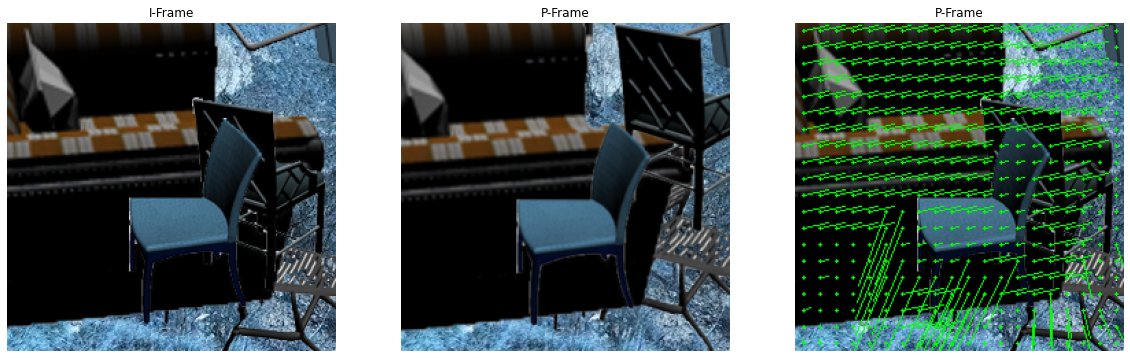

In [8]:
import flyingchairs_data_loader
import helpers


FLAGS = helpers.FlyingChairsFlags()
data_gen = flyingchairs_data_loader.DataLoader(FLAGS.data_dir, FLAGS.train_list, FLAGS.val_list)
train_dataset, val_dataset = data_gen.create_tf_dataset(FLAGS)
for im_pairs, flo_gt in train_dataset:
    im1 = im_pairs[0, :, :, :3]
    im2 = im_pairs[0, :, :, 3:]
    
    helpers.plot_ip_f(im1.numpy(), im2.numpy(), flo_gt[0])
    break

In [9]:
metrics_names = ['train_loss_mse','train_loss_mse_w'] 
accuracy_names = ['train_accuracy', 'train_accuracy_w']

train_loss = tf.keras.metrics.Mean(metrics_names[0], dtype=tf.float32)
train_accuracy = tf.keras.metrics.MeanAbsoluteError(accuracy_names[0], dtype=tf.float32)
train_loss_w = tf.keras.metrics.Mean(metrics_names[1], dtype=tf.float32)
train_accuracy_w = tf.keras.metrics.MeanAbsoluteError(accuracy_names[1], dtype=tf.float32)


# Instantiate an optimizer.
optimizer_w = tf.keras.optimizers.Adam(learning_rate=lr_init)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_init)
num_of_training_samples = STEPS_PER_EPOCH
  
data_gen = flyingchairs_data_loader.DataLoader(FLAGS.data_dir, FLAGS.train_list, FLAGS.val_list)

# Iterate over the batches of a dataset.
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1, EPOCHS))
    
    progBar = tf.keras.utils.Progbar(num_of_training_samples, stateful_metrics=metrics_names)
    cnt = 0
    for im_pairs, gt_flow in train_dataset:
        im1 = im_pairs[:, :, :, :3]
        im2 = im_pairs[:, :, :, 3:]
    
        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            loss_value, logits = model([im1, im2], training=True)
            # Loss value for this batch.
        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        # print(loss_value)
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_loss(loss_value)
        # train_accuracy(x[0], logits)
        
        with tf.GradientTape() as tape_w:
            # Forward pass.
            loss_value_w, logits_w = model_w([im1, im2], training=True)
            # Loss value for this batch.
        # Get gradients of loss wrt the weights.
        gradients_w = tape_w.gradient(loss_value_w, model_w.trainable_weights)
        # print(loss_value)
        # Update the weights of the model.
        optimizer_w.apply_gradients(zip(gradients_w, model_w.trainable_weights))
        train_loss_w(loss_value_w)
        # train_accuracy(x[0], logits_w)
        
        
        values=[('train_loss',train_loss.result()), ('train_loss_w',train_loss_w.result())]
        progBar.update(cnt, values=values) 
        
        if cnt == STEPS_PER_EPOCH:
            break
        
        cnt += 1
            
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=(epoch+1))
        
    with train_w_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss_w.result(), step=(epoch+1))
                
    print(template.format(epoch+1,loss_value_w, loss_value))     
    helpers.plot_ip_ff_vv(im1[0].numpy(),im2[0].numpy(), logits[0], logits_w[0])   
    helpers.plot_ip_f(im1[0].numpy(),im2[0].numpy(), gt_flow[0],(20,20), False)
    progBar.update(num_of_training_samples, values=values, finalize=True)


epoch 1/10


2022-12-23 22:52:02.598981: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
